<a href="https://colab.research.google.com/github/devdoe153/llm-proj/blob/main/1_CIFAR10_%EA%B3%BC%EC%A0%9C2_%EB%8F%84%EC%83%81%EC%A7%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [2]:
transform = transforms.ToTensor()

# CIFAR-10 데이터셋 로드
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 170498071/170498071 [00:05<00:00, 28566048.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

50000
torch.Size([3, 32, 32]) 6


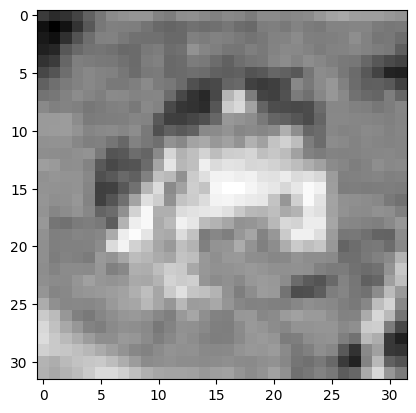

In [3]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [4]:
# 배치 사이즈
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [7]:
from torch import nn


# 모델정의 ( 활성화 함수 nn.LeakyReLu 사용)

class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

model_sgd = Model(32 * 32 * 3, 1024).to('cuda') # sgd 모델
model_adam = Model(32 * 32 * 3, 1024).to('cuda') # adam 모델

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [ ]:
!CUDA_LAUNCH_BLOCKING=1

In [8]:
from torch.optim import SGD, Adam

lr = 0.001

criterion = nn.CrossEntropyLoss()

optimizer_sgd = SGD(model_sgd.parameters(), lr=lr)
optimizer_adam = Adam(model_adam.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [9]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [10]:
n_epochs = 50 # 50 설정
train_accs_sgd = []
train_accs_adam = []
# test_accs = []

for epoch in range(n_epochs):

  # 모델 Adam 학습
  model_adam.train()
  total_loss_adam = 0.0
  for data in trainloader:
    model_sgd.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    optimizer_adam.zero_grad()
    preds = model_adam(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer_adam.step()

    total_loss_adam += loss.item()

  # Epoch 끝날 때마다 정확도 측정
  train_acc_adam = accuracy(model_adam, trainloader)
  # test_acc = accuracy(model, testloader)
  train_accs_adam.append(train_acc_adam)
  # test_accs.append(test_acc)

  # 모델 SGD 학습
  model_sgd.train()
  total_loss_sgd = 0.0
  for data in trainloader:
    model_sgd.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    optimizer_sgd.zero_grad()
    preds = model_sgd(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer_sgd.step()

    total_loss_sgd += loss.item()

  # Epoch 끝날 때마다 정확도 측정
  train_acc_sgd = accuracy(model_sgd, trainloader)
  # test_acc = accuracy(model, testloader)
  train_accs_sgd.append(train_acc_sgd)
  # test_accs.append(test_acc)

  print(f"Epoch {epoch+1}/{n_epochs}, SGD Loss: {total_loss_sgd:.4f}, Adam Loss: {total_loss_adam:.4f}")
  print(f"SGD Train Acc: {train_acc_sgd:.4f}, Adam Train Acc: {train_acc_adam:.4f}")

Epoch 1/50, SGD Loss: 450.5522, Adam Loss: 370.6016
SGD Train Acc: 0.1143, Adam Train Acc: 0.3885
Epoch 2/50, SGD Loss: 448.3212, Adam Loss: 325.9457
SGD Train Acc: 0.1633, Adam Train Acc: 0.4143
Epoch 3/50, SGD Loss: 446.5248, Adam Loss: 306.6576
SGD Train Acc: 0.1609, Adam Train Acc: 0.4512
Epoch 4/50, SGD Loss: 444.7990, Adam Loss: 295.5823
SGD Train Acc: 0.1696, Adam Train Acc: 0.4462
Epoch 5/50, SGD Loss: 443.0233, Adam Loss: 285.4637
SGD Train Acc: 0.1852, Adam Train Acc: 0.4906
Epoch 6/50, SGD Loss: 441.0911, Adam Loss: 278.9205
SGD Train Acc: 0.1937, Adam Train Acc: 0.4978
Epoch 7/50, SGD Loss: 439.0068, Adam Loss: 271.5809
SGD Train Acc: 0.2132, Adam Train Acc: 0.5174
Epoch 8/50, SGD Loss: 436.7305, Adam Loss: 264.0783
SGD Train Acc: 0.2229, Adam Train Acc: 0.5128
Epoch 9/50, SGD Loss: 434.2292, Adam Loss: 258.6842
SGD Train Acc: 0.2284, Adam Train Acc: 0.5519
Epoch 10/50, SGD Loss: 431.5510, Adam Loss: 251.8737
SGD Train Acc: 0.2372, Adam Train Acc: 0.5543
Epoch 11/50, SGD Lo

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

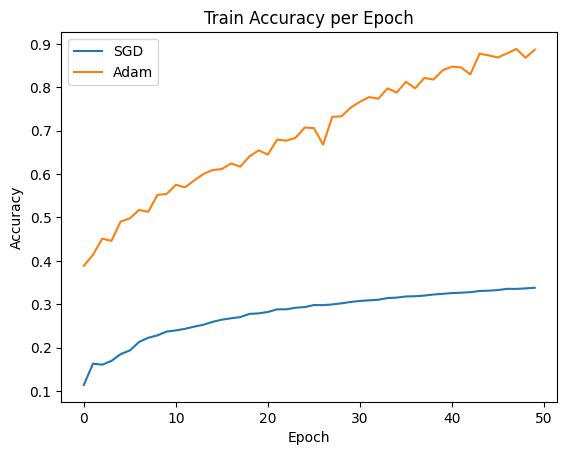

In [11]:
# 정확도 시각화
import numpy as np
import matplotlib.pyplot as plt

# 6. 정확도 그래프 그리기
def plot_acc(train_accs_sgd, train_accs_adam):
    x = np.arange(len(train_accs_sgd))
    plt.plot(x, train_accs_sgd, label='SGD')
    plt.plot(x, train_accs_adam, label='Adam')
    plt.legend()
    plt.title('Train Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

# SGD와 Adam의 학습 정확도 비교 플롯
plot_acc(train_accs_sgd, train_accs_adam)

In [13]:
# Leaky ReLU와 Sigmoid 성능 비교

# LeakyReLUModel 모델 정의 (활성화 함수: Leaky ReLU)
class LeakyReLUModel(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)
        self.act = nn.LeakyReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)
        return x

# SigmoidModel 모델 정의 (활성화 함수: Sigmoid)
class SigmoidModel(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)
        return x


In [16]:
# CIFAR10 이미지를 위한 모델 입력 크기 조정 (3 * 32 * 32)
model_leaky_relu = LeakyReLUModel(32 * 32 * 3, 1024).to('cuda')
model_sigmoid = SigmoidModel(32 * 32 * 3, 1024).to('cuda')

# 손실 함수
criterion = nn.CrossEntropyLoss()

# Adam 옵티마이저 설정
optimizer_leaky_relu = Adam(model_leaky_relu.parameters(), lr=0.001)
optimizer_sigmoid = Adam(model_sigmoid.parameters(), lr=0.001)

In [18]:
# 학습 루프 (Leaky ReLU와 Sigmoid에 대해 각각 Adam을 사용하여 학습)
n_epochs = 50
train_accs_leaky_relu = []
train_accs_sigmoid = []

for epoch in range(n_epochs):
    # Leaky ReLU 모델 학습
    model_leaky_relu.train()
    total_loss_leaky_relu = 0.0
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer_leaky_relu.zero_grad()
        preds = model_leaky_relu(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer_leaky_relu.step()
        total_loss_leaky_relu += loss.item()

    train_acc_leaky_relu = accuracy(model_leaky_relu, trainloader)
    train_accs_leaky_relu.append(train_acc_leaky_relu)

    # Sigmoid 모델 학습
    model_sigmoid.train()
    total_loss_sigmoid = 0.0
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer_sigmoid.zero_grad()
        preds = model_sigmoid(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer_sigmoid.step()
        total_loss_sigmoid += loss.item()

    train_acc_sigmoid = accuracy(model_sigmoid, trainloader)
    train_accs_sigmoid.append(train_acc_sigmoid)

    print(f"Epoch {epoch+1}/{n_epochs}, Leaky ReLU Loss: {total_loss_leaky_relu:.4f}, Sigmoid Loss: {total_loss_sigmoid:.4f}")
    print(f"Leaky ReLU Train Acc: {train_acc_leaky_relu:.4f}, Sigmoid Train Acc: {train_acc_sigmoid:.4f}")


Epoch 1/50, Leaky ReLU Loss: 66.5974, Sigmoid Loss: 152.5296
Leaky ReLU Train Acc: 0.9027, Sigmoid Train Acc: 0.7120
Epoch 2/50, Leaky ReLU Loss: 59.5842, Sigmoid Loss: 151.0596
Leaky ReLU Train Acc: 0.8810, Sigmoid Train Acc: 0.7326
Epoch 3/50, Leaky ReLU Loss: 58.0495, Sigmoid Loss: 148.4997
Leaky ReLU Train Acc: 0.9033, Sigmoid Train Acc: 0.7425
Epoch 4/50, Leaky ReLU Loss: 53.3536, Sigmoid Loss: 146.3732
Leaky ReLU Train Acc: 0.9077, Sigmoid Train Acc: 0.7292
Epoch 5/50, Leaky ReLU Loss: 53.3746, Sigmoid Loss: 144.1752
Leaky ReLU Train Acc: 0.9238, Sigmoid Train Acc: 0.7412
Epoch 6/50, Leaky ReLU Loss: 50.7407, Sigmoid Loss: 139.5907
Leaky ReLU Train Acc: 0.9107, Sigmoid Train Acc: 0.7580
Epoch 7/50, Leaky ReLU Loss: 50.2061, Sigmoid Loss: 139.7189
Leaky ReLU Train Acc: 0.9214, Sigmoid Train Acc: 0.7351
Epoch 8/50, Leaky ReLU Loss: 49.0875, Sigmoid Loss: 138.8778
Leaky ReLU Train Acc: 0.9261, Sigmoid Train Acc: 0.7594
Epoch 9/50, Leaky ReLU Loss: 45.4182, Sigmoid Loss: 136.8615
Lea

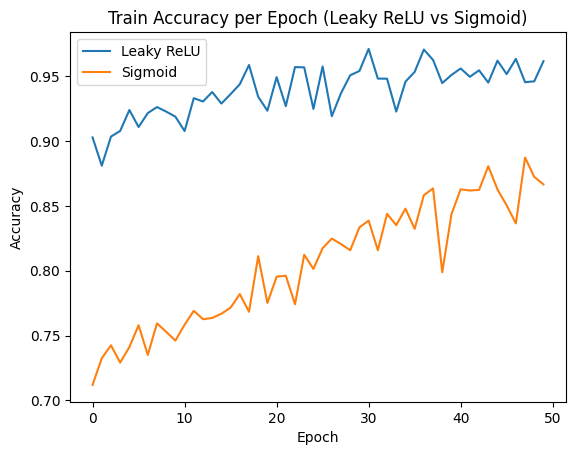

In [21]:
# 정확도 그래프 그리기
def plot_acc(train_accs_leaky_relu, train_accs_sigmoid):
    x = np.arange(len(train_accs_leaky_relu))
    plt.plot(x, train_accs_leaky_relu, label='Leaky ReLU')
    plt.plot(x, train_accs_sigmoid, label='Sigmoid')
    plt.legend()
    plt.title('Train Accuracy per Epoch (Leaky ReLU vs Sigmoid)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

# Leaky ReLU와 Sigmoid의 학습 정확도 비교 플롯
plot_acc(train_accs_leaky_relu, train_accs_sigmoid)

In [22]:
#  Dropout이 적용된 LeakyReLU 모델 정의
class DropoutLeakyReLUModel(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.1)  # Dropout 확률을 0.1로 설정

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.act(self.layer1(x)))  # Dropout 적용
        x = self.dropout(self.act(self.layer2(x)))  # Dropout 적용
        x = self.layer3(x)
        return x

# CIFAR10 이미지를 위한 모델 입력 크기 조정 (3 * 32 * 32)
model_dropout = DropoutLeakyReLUModel(32 * 32 * 3, 1024).to('cuda')


In [23]:

# 손실 함수 및 Adam 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer_dropout = Adam(model_dropout.parameters(), lr=0.001)

In [24]:
# 학습 루프 (Dropout 모델에 대해 Adam을 사용하여 학습)
n_epochs = 50
train_accs_dropout = []
test_accs_dropout = []

for epoch in range(n_epochs):
    # Dropout 모델 학습
    model_dropout.train()  # Dropout을 활성화하여 학습 모드로 전환
    total_loss_dropout = 0.0
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer_dropout.zero_grad()
        preds = model_dropout(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer_dropout.step()
        total_loss_dropout += loss.item()

    # 학습 데이터 정확도 계산 (Dropout 적용)
    with torch.no_grad():
        model_dropout.eval()  # Dropout을 비활성화하여 평가 모드로 전환
        train_acc_dropout = accuracy(model_dropout, trainloader)
        test_acc_dropout = accuracy(model_dropout, testloader)

    train_accs_dropout.append(train_acc_dropout)
    test_accs_dropout.append(test_acc_dropout)

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss_dropout:.4f}, Train Acc: {train_acc_dropout:.4f}, Test Acc: {test_acc_dropout:.4f}")

Epoch 1/50, Loss: 370.1768, Train Acc: 0.3400, Test Acc: 0.3395
Epoch 2/50, Loss: 331.4614, Train Acc: 0.4316, Test Acc: 0.4293
Epoch 3/50, Loss: 314.4338, Train Acc: 0.4479, Test Acc: 0.4419
Epoch 4/50, Loss: 304.7208, Train Acc: 0.4657, Test Acc: 0.4537
Epoch 5/50, Loss: 297.2483, Train Acc: 0.4652, Test Acc: 0.4522
Epoch 6/50, Loss: 290.1085, Train Acc: 0.4860, Test Acc: 0.4700
Epoch 7/50, Loss: 284.6672, Train Acc: 0.5056, Test Acc: 0.4849
Epoch 8/50, Loss: 280.2677, Train Acc: 0.4979, Test Acc: 0.4755
Epoch 9/50, Loss: 275.2131, Train Acc: 0.5315, Test Acc: 0.5007
Epoch 10/50, Loss: 269.1860, Train Acc: 0.5257, Test Acc: 0.4911
Epoch 11/50, Loss: 265.9162, Train Acc: 0.5363, Test Acc: 0.4986
Epoch 12/50, Loss: 261.2102, Train Acc: 0.5457, Test Acc: 0.5099
Epoch 13/50, Loss: 257.7832, Train Acc: 0.5576, Test Acc: 0.5139
Epoch 14/50, Loss: 253.8831, Train Acc: 0.5665, Test Acc: 0.5190
Epoch 15/50, Loss: 250.3286, Train Acc: 0.5806, Test Acc: 0.5254
Epoch 16/50, Loss: 247.0557, Train

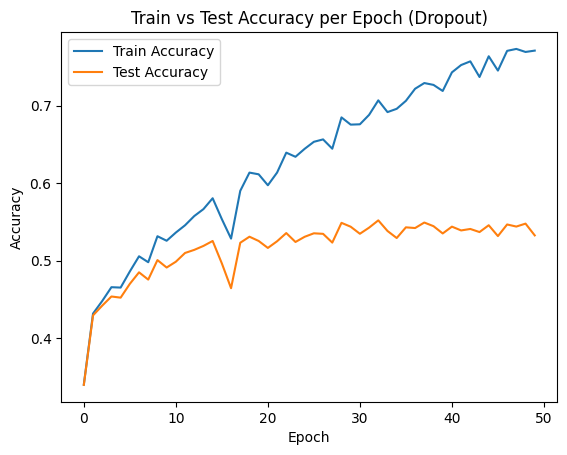

In [25]:
# 정확도 그래프 그리기 (Train vs Test)
def plot_acc(train_accs_dropout, test_accs_dropout):
    x = np.arange(len(train_accs_dropout))
    plt.plot(x, train_accs_dropout, label='Train Accuracy')
    plt.plot(x, test_accs_dropout, label='Test Accuracy')
    plt.legend()
    plt.title('Train vs Test Accuracy per Epoch (Dropout)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

# Dropout이 적용된 모델의 Train과 Test 정확도 비교 플롯
plot_acc(train_accs_dropout, test_accs_dropout)